In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product
from math import ceil

In [2]:
DATA = Path("..","data","processed")
SECTORS = ["E", "H", "EH"]
PRICES = ["high", "mid", "low", "vlow"]
EMISSIONS = ["20", "35", "50"]
SECTOR_NICE_NAMES = {
    "E": "Electrical",
    "H": "Thermal",
    "EH": "Electrical\nand Thermal"
}
PRICE_NICE_NAMES = {
    "vlow": "Very\nLow",
    "low": "Low",
    "mid": "Mid",
    "high": "High"
}

In [3]:
def get_dataframe(emission: str, result: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.DataFrame:
    if not (sector or price):
        scenario = f"er{emission}"
    else:
        scenario = f"{sector}dr-{price}-er{emission}" 
    p = Path(DATA, scenario, "datapoint", f"{result}.csv")
    return pd.read_csv(p, index_col=0)

In [4]:
def get_template_dataframe() -> pd.DataFrame:
    prices = PRICES.copy()
    prices.insert(0, "None")
    sectors = SECTORS.copy()
    sectors.insert(0, "None")
    return pd.DataFrame([],
        index=sectors,
        columns=prices
    )
get_template_dataframe()

,None,high,mid,low,vlow
None,NaN,NaN,NaN,NaN,NaN
E,NaN,NaN,NaN,NaN,NaN
H,NaN,NaN,NaN,NaN,NaN
EH,NaN,NaN,NaN,NaN,NaN


In [5]:
def get_heatmap_data(result: str, metric: str) -> dict[str, pd.DataFrame]:
    data = {}
    for emission in EMISSIONS:
        hm = get_template_dataframe()
        for sector, price in product(SECTORS, PRICES):
            df = get_dataframe(
                emission=emission,
                result=result,
                sector=sector,
                price=price
            )
            datapoint = df.at[metric, "value"]
            hm.at[sector, price] = datapoint
        df = get_dataframe(emission=emission, result=result)
        datapoint = df.at[metric, "value"]
        hm.at["None", "None"] = datapoint
        data[f"er{emission}"] = hm.astype(float)
    return data

In [6]:
def generate_heatmap(data: dict[str, pd.DataFrame], scaler: Optional[float] = None, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    if not scaler:
        scaler = 1
    
    ncols = 2
    nrows = ceil(3 / ncols)
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))
    
    row = 0
    col = 0
    
    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)
    
    for er, df in data.items():
        
        # df = df[["high", "mid", "low", "None"]].T
        df = df.T.rename(index=PRICE_NICE_NAMES).rename(columns=SECTOR_NICE_NAMES)
        
        title = f"{er[-2:]}% Emission Reduction"
        
        df = df.div(scaler).round(2)
        
        sns.heatmap(df, annot=True, cmap="crest", ax=axs[row, col], fmt=".1f")
        
        axs[row, col].set_title(title, fontsize=14)
        axs[row, col].tick_params(axis="y", labelrotation=0)
        
        col += 1
        if col > 1:
            col = 0
            row += 1
        
    if col != 0:
        axs[row, 1].axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.99])
        
    return fig, axs

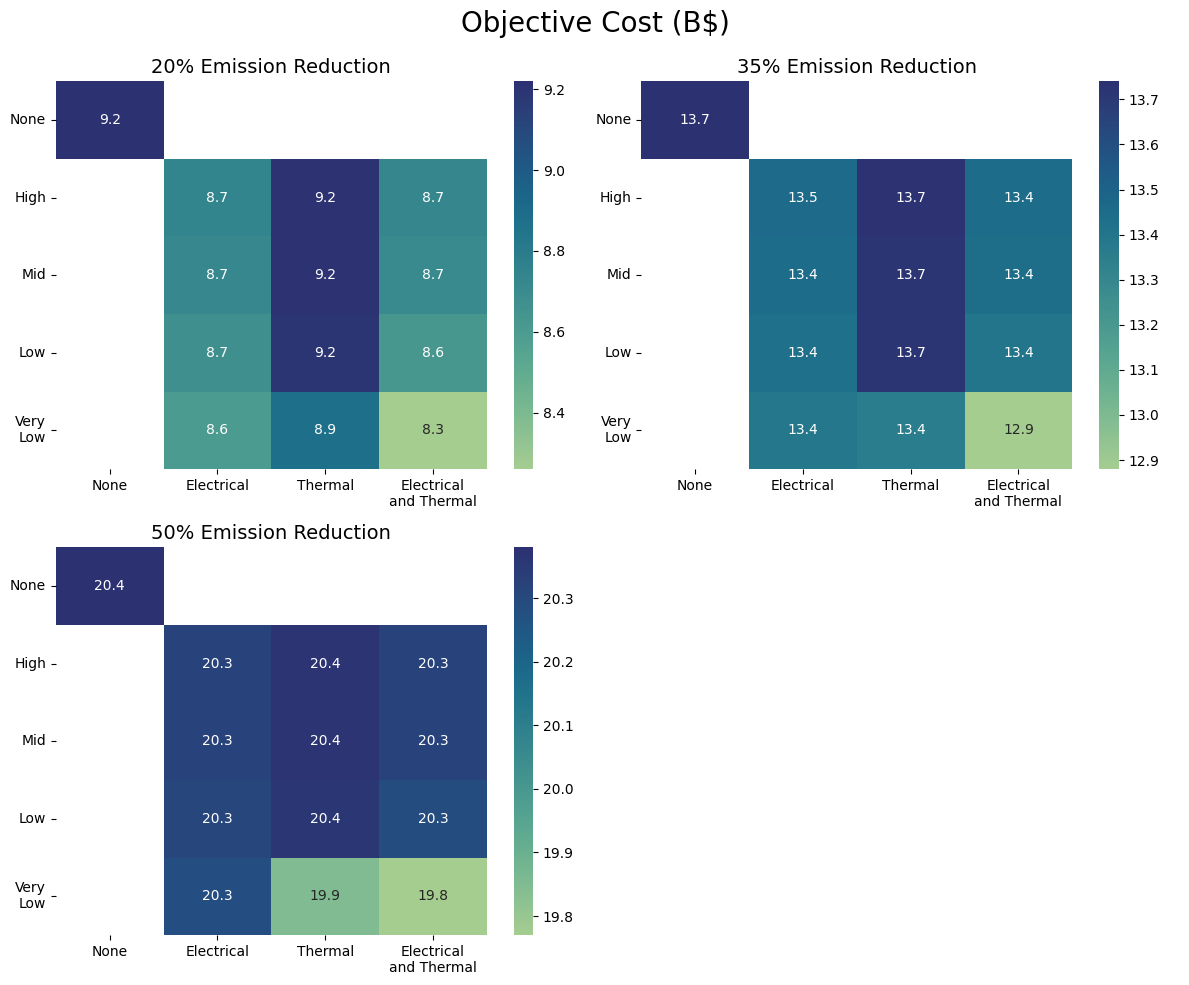

In [7]:
objective_cost = get_heatmap_data("cost", "objective")
fig, ax = generate_heatmap(objective_cost, scaler=1e9, title="Objective Cost (B$)")

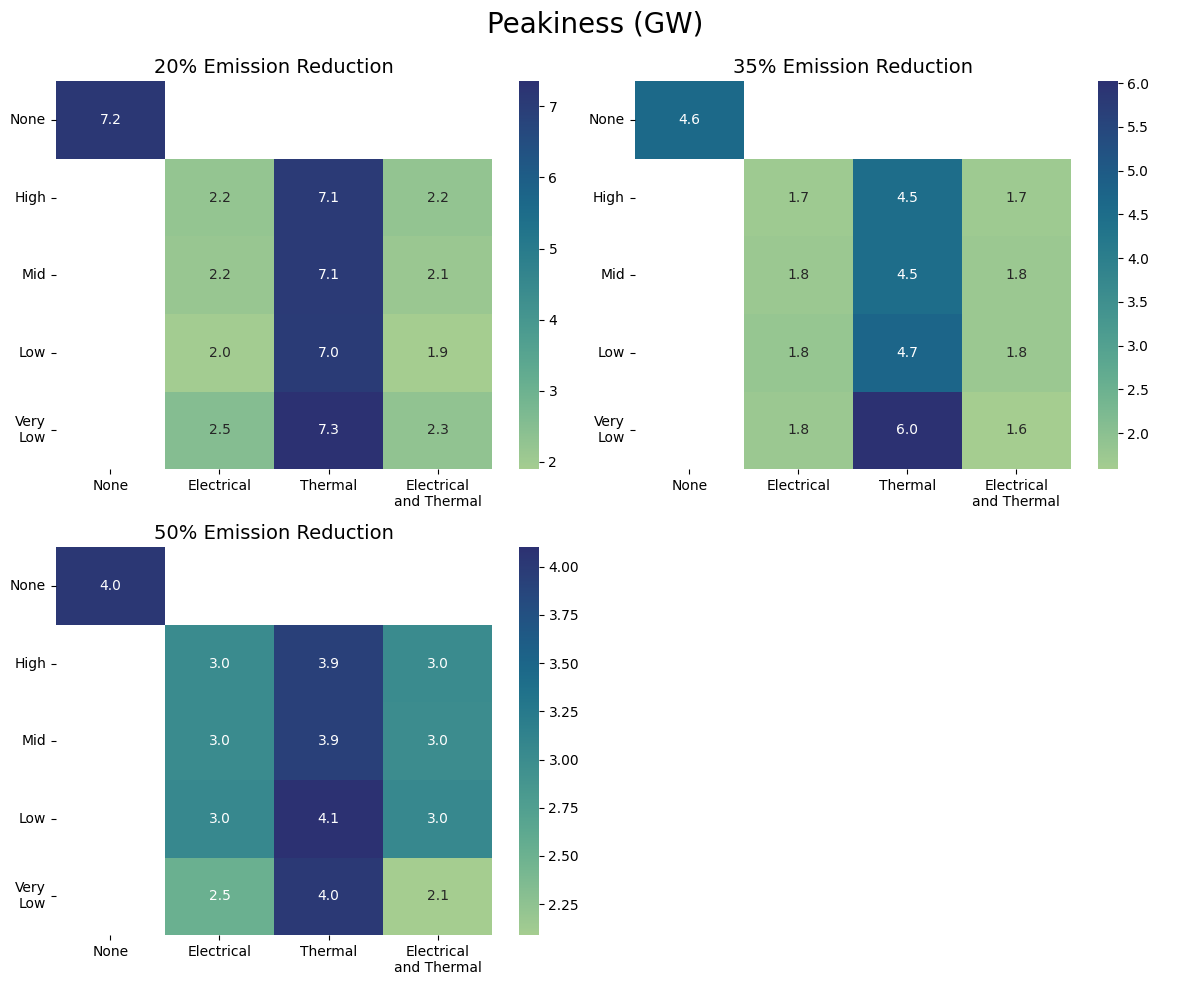

In [8]:
peakiness = get_heatmap_data("peakiness", "peakiness")
fig, ax = generate_heatmap(peakiness, scaler=1e3, title="Peakiness (GW)")

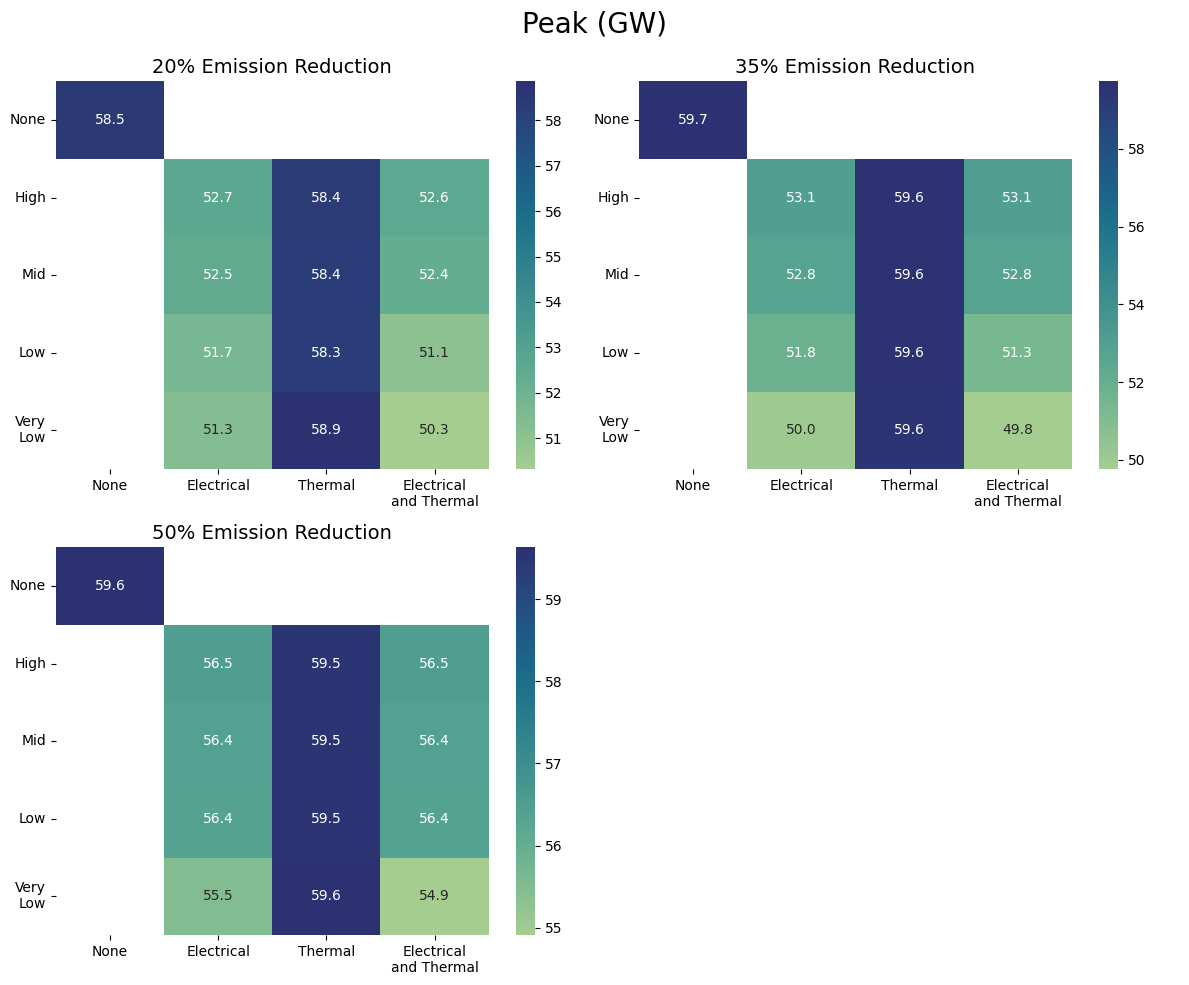

In [9]:
peak = get_heatmap_data("peakiness", "peak")
fig, ax = generate_heatmap(peak, scaler=1e3, title="Peak (GW)")

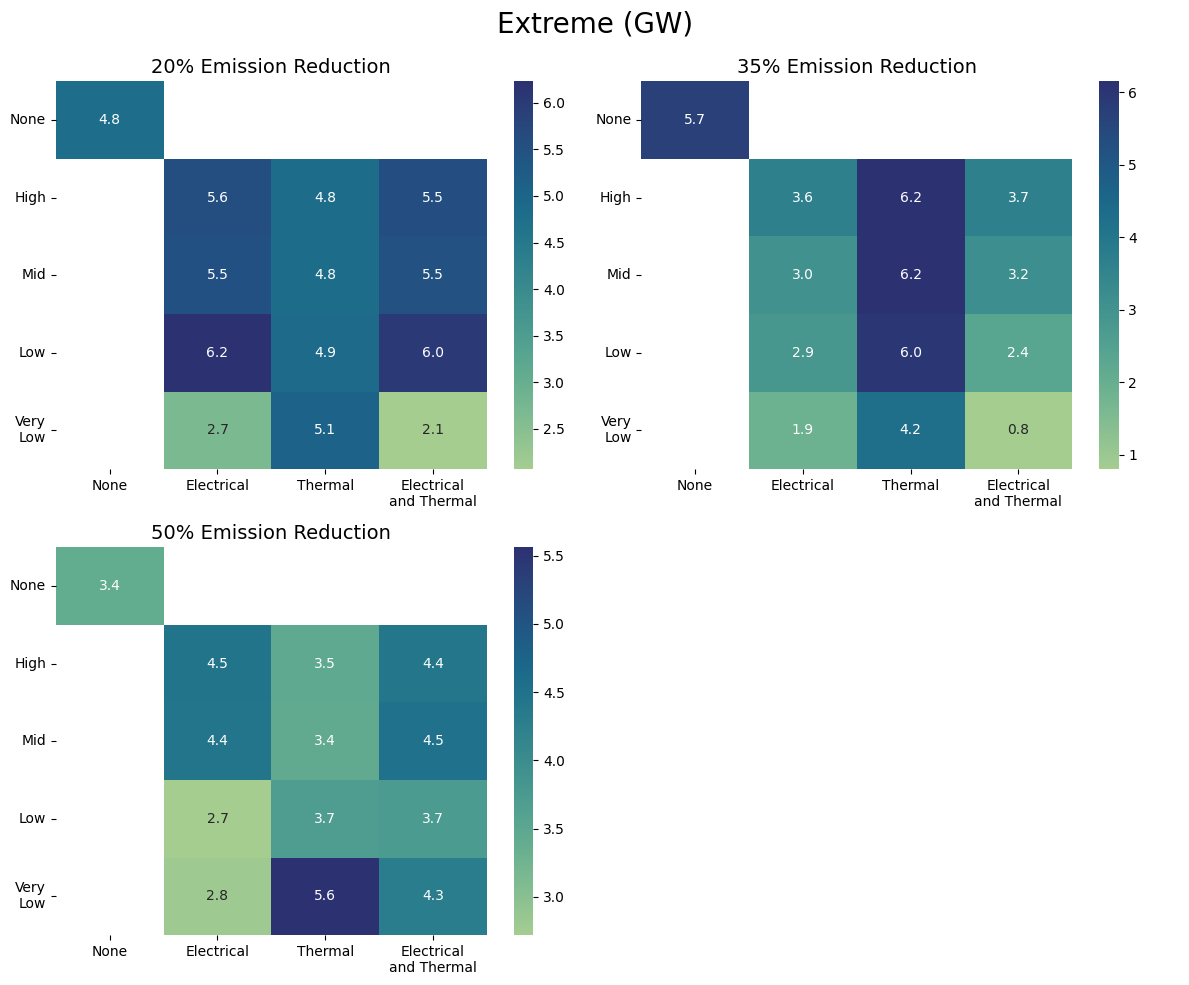

In [10]:
extreme = get_heatmap_data("ramping", "peakiness")
fig, ax = generate_heatmap(extreme, scaler=1e3, title="Extreme (GW)")

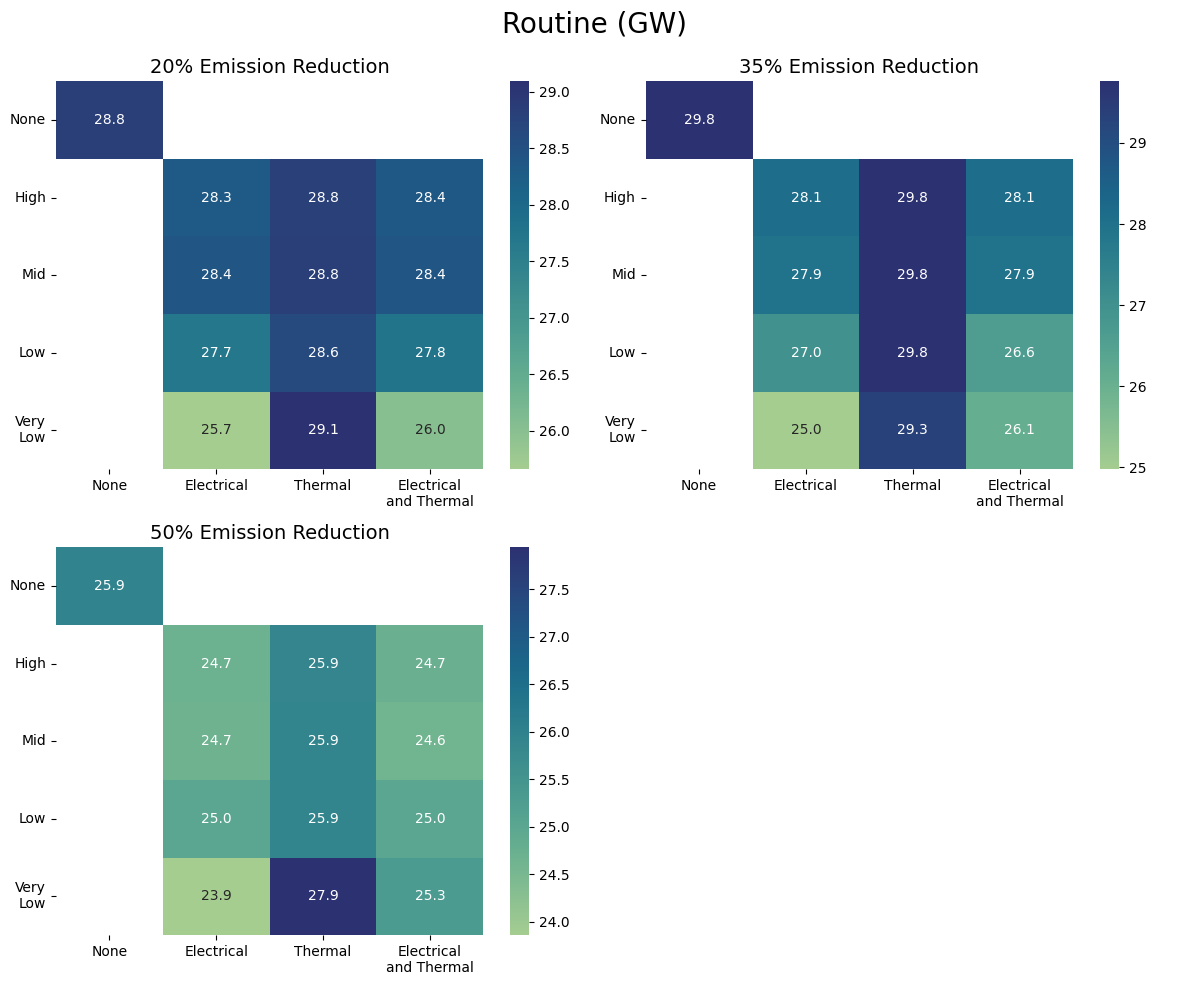

In [11]:
routine = get_heatmap_data("ramping", "rountine")
fig, ax = generate_heatmap(routine, scaler=1e3, title="Routine (GW)")

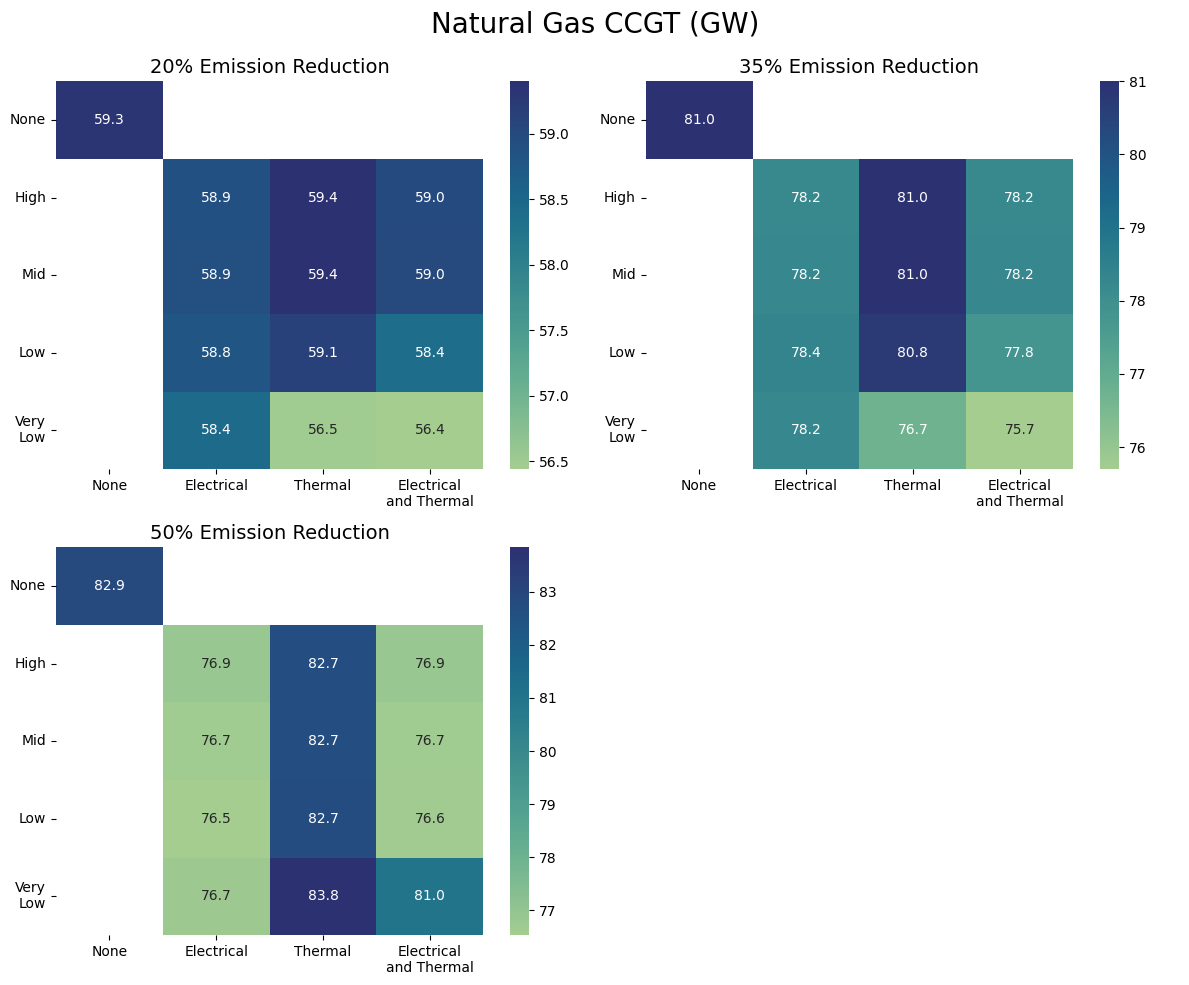

In [12]:
routine = get_heatmap_data("capacity", "Natural Gas CCGT")
fig, ax = generate_heatmap(routine, scaler=1e3, title="Natural Gas CCGT (GW)")

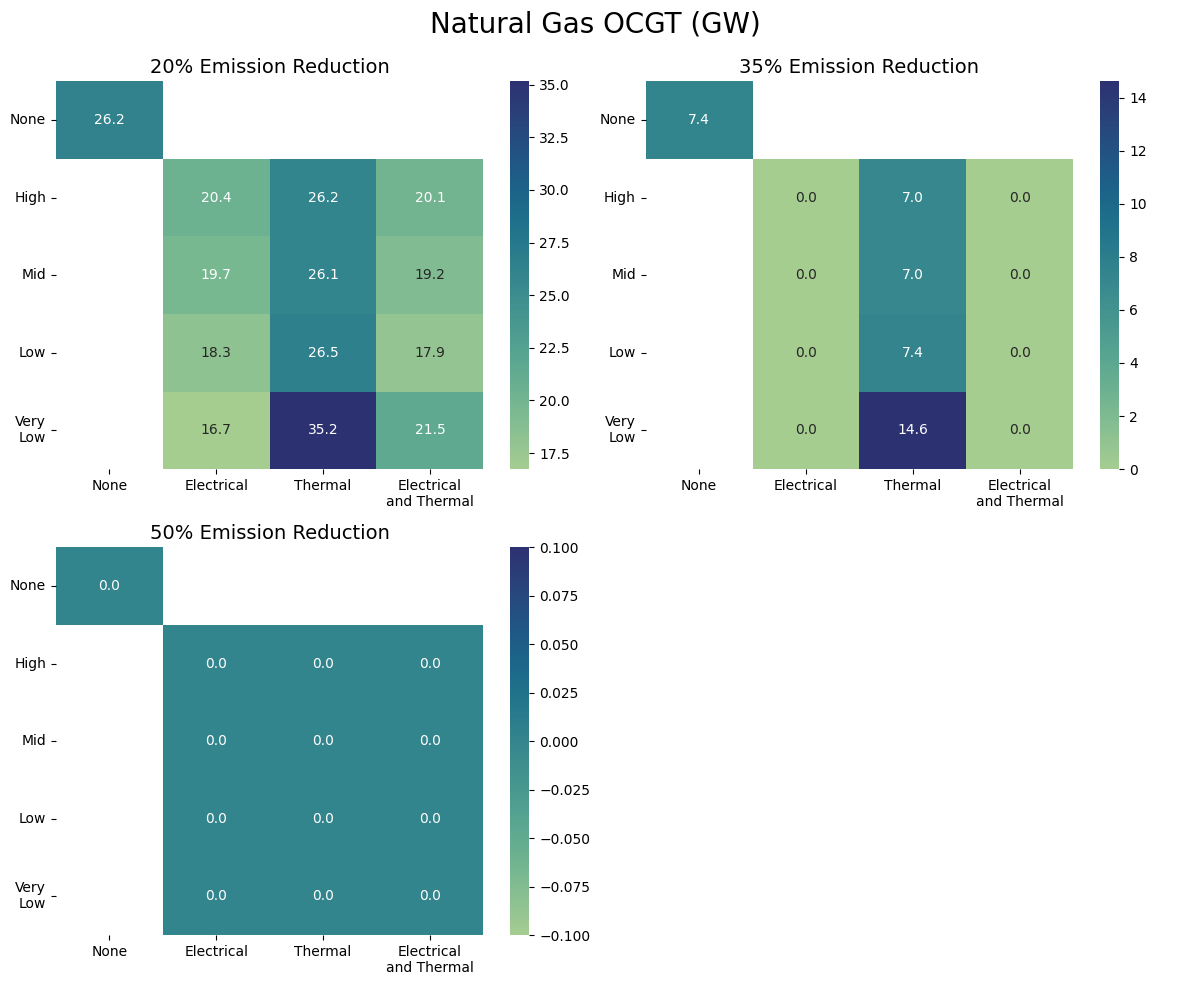

In [13]:
routine = get_heatmap_data("capacity", "Natural Gas OCGT")
fig, ax = generate_heatmap(routine, scaler=1e3, title="Natural Gas OCGT (GW)")

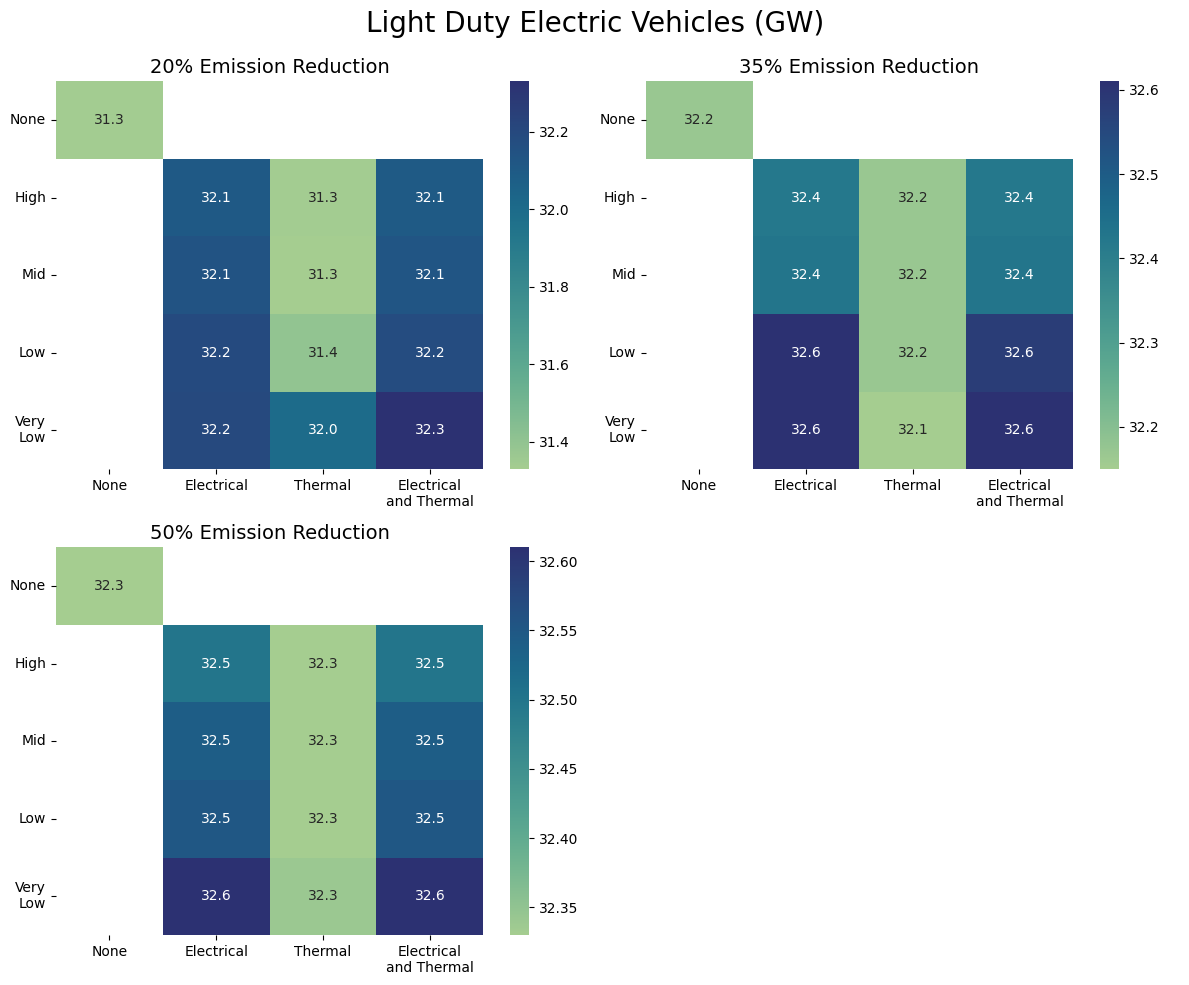

In [14]:
routine = get_heatmap_data("capacity", "Transport Electric Light")
fig, ax = generate_heatmap(routine, scaler=1e3, title="Light Duty Electric Vehicles (GW)")

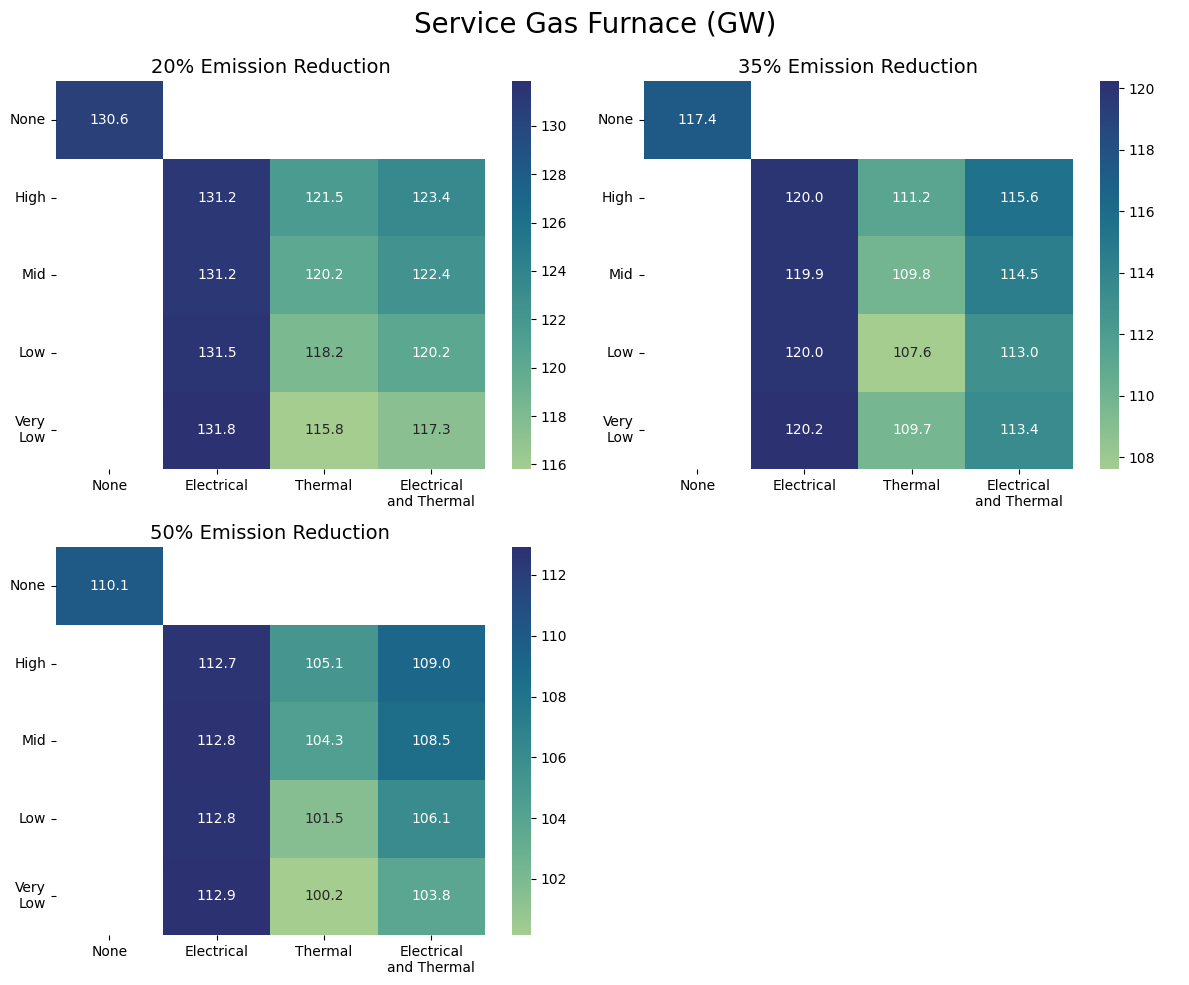

In [16]:
routine = get_heatmap_data("capacity", "Service Gas Furnace")
fig, ax = generate_heatmap(routine, scaler=1e3, title="Service Gas Furnace (GW)")

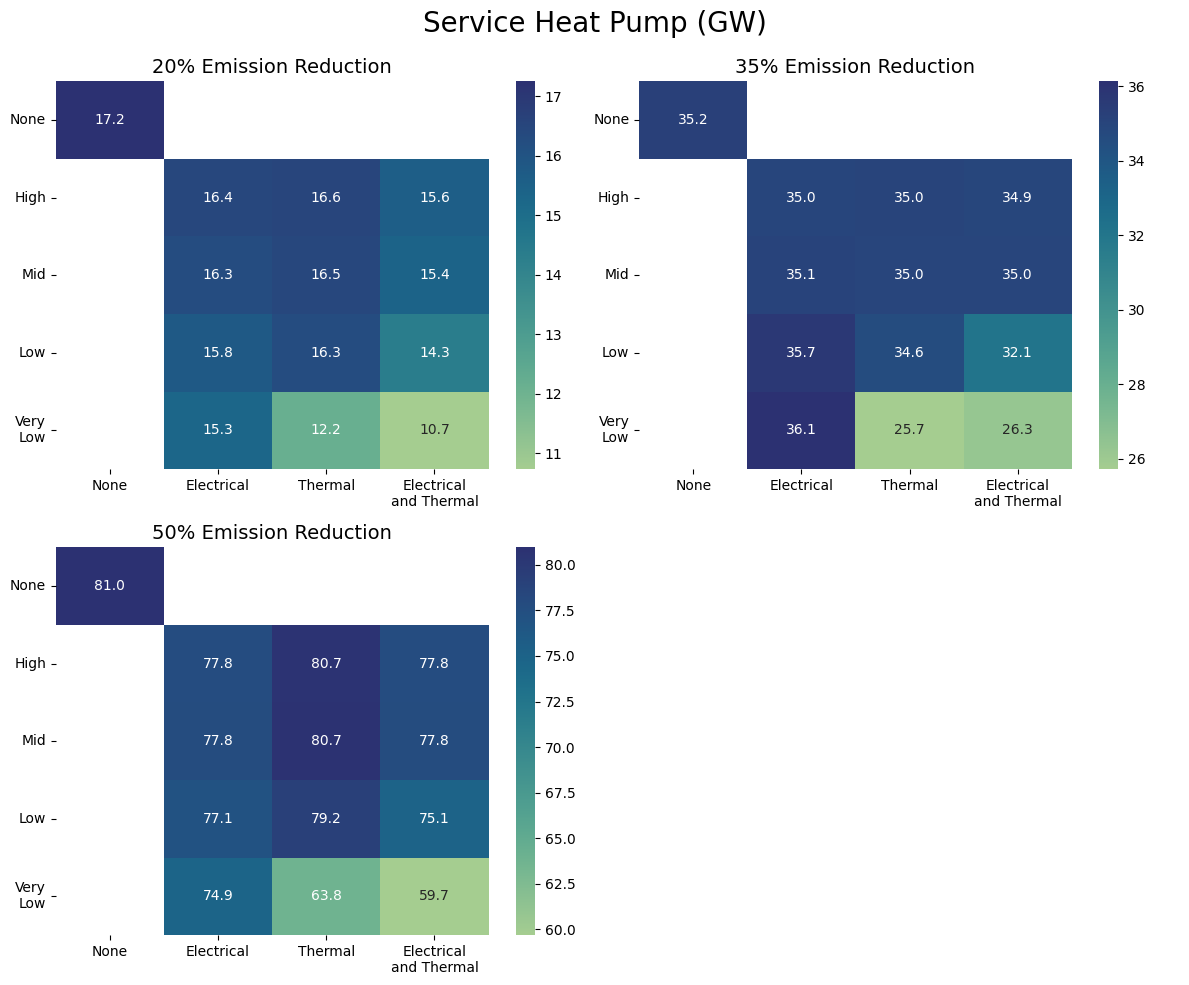

In [18]:
routine = get_heatmap_data("capacity", "Service Heat Pump")
fig, ax = generate_heatmap(routine, scaler=1e3, title="Service Heat Pump (GW)")